___
this notebook select features that are important before throwing into the model

In [166]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_selection import *
from sklearn import *
from scipy import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from aggregate_function import build_features_table, combine_features_table, coach_stats, win_rate_type_of_location

In [2]:
coach_file = 'data/DataFiles/TeamCoaches.csv'
regularseason_file = 'data/DataFiles/RegularSeasonDetailedResults.csv'
postseason_file = 'data/DataFiles/NCAATourneyCompactResults.csv'

In [3]:
initial_features = build_features_table.BuildFeaturesTable(regularseason_file)
win_rate_features = win_rate_type_of_location.WinRateTypeLocation(regularseason_file)
coach_features = coach_stats.CoachStats(coach_file,regularseason_file,postseason_file)

features = combine_features_table.CombineFeaturesTable(initial_features,win_rate_features,coach_features)

## Feature Selection on Correlation Matrix
- remove features that are highly correlated

In [4]:
features_table = (
    features.final_table_processed
    .drop(['Season','TeamID'],1)
)

corr = features_table.corr()
# features_table.corr(method='pearson').to_csv("correlation_matrix.csv")

columns to be excluded
- total score
- total rebounds
- total blocks
- total assist turnover ratio
- E(X) per game
- win rate
- total rebound possession per game
- win_rate_overall coach

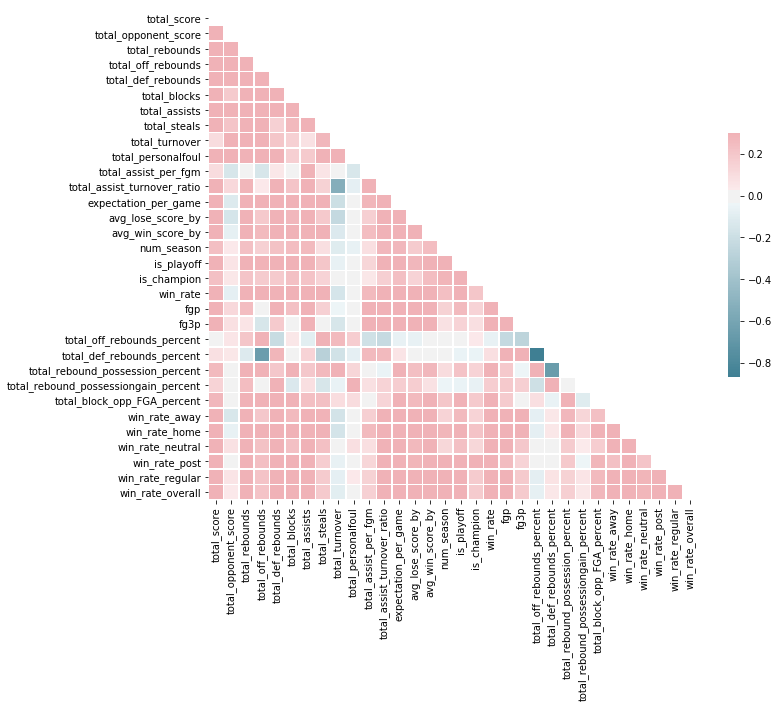

In [5]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
features_table = (
    features.final_table_processed
    .drop(['Season','TeamID','total_score','total_rebounds','total_blocks','total_assist_turnover_ratio','expectation_per_game',
           'win_rate','total_rebound_possession_percent','win_rate_overall','total_off_rebounds_percent','total_def_rebounds_percent'
          ],1)
    .fillna(0)
)

## Feature selection from collinearity
- remove features that are collinearity
- features are then passed through variance threshold before passing into models for feature selection

In [7]:
vif = pd.DataFrame()
vif['VIF_factor'] = [variance_inflation_factor(features_table.values, i) for i in range(features_table.shape[1])]
vif['features'] = features_table.columns

features to further remove
- total_opponent_score
- total_rebound_possessiongain_percent 
- fg3p

In [8]:
features_table = (
    features.final_table_processed
    .drop(['Season','TeamID','total_score','total_rebounds','total_blocks','total_assist_turnover_ratio','expectation_per_game',
           'win_rate','total_rebound_possession_percent','win_rate_overall','total_off_rebounds_percent','total_def_rebounds_percent',
           'total_opponent_score','total_rebound_possessiongain_percent','fg3p'
          ],1)
    .fillna(0)
)

vif = pd.DataFrame()
vif['VIF_factor'] = [variance_inflation_factor(features_table.values, i) for i in range(features_table.shape[1])]
vif['features'] = features_table.columns
vif

,VIF_factor,features
0,59.678789,total_off_rebounds
1,171.697655,total_def_rebounds
2,154.510210,total_assists
3,42.687173,total_steals
4,113.922969,total_turnover
5,121.895944,total_personalfoul
6,181.664577,total_assist_per_fgm
7,52.321586,avg_lose_score_by
8,19.293925,avg_win_score_by
9,5.960765,num_season


## Feature selection from PCA explained variance
- use PCA to see how much variance does the feature account for, selecting up to 99% variance would be good enough
- 15 features are enough for variance
    - this doesnt tell us which features to discard but in the model selection of feature importance
    - we can tell the model to choose up to 12 features max

In [9]:
covar_matrix = PCA(n_components = 19)

covar_matrix.fit(features_table)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([ 44.5,  61.8,  71.7,  79.6,  84.3,  87.9,  90.7,  92.4,  94. ,
        95.4,  96.5,  97.5,  98.3,  98.9,  99.3,  99.6,  99.8,  99.9,  99.9])

## Final data transformation for feature table
- post season is only what we care about
- post season match ups will be what we are joining all the features table to
- additional variable of seeding differential

In [10]:
features_table = (
    features.final_table_processed
    .drop(['total_score','total_rebounds','total_blocks','total_assist_turnover_ratio','expectation_per_game',
           'win_rate','total_rebound_possession_percent','win_rate_overall','total_off_rebounds_percent','total_def_rebounds_percent',
           'total_opponent_score','total_rebound_possessiongain_percent','fg3p'
          ],1)
    .fillna(0)
)

In [11]:
seeding_data = pd.read_csv("input/tour-results-seed.csv")

In [12]:
winning_team_perspective_df = (
    seeding_data
    .pipe(lambda x:x.assign(diff_seed = x.L_seed - x.W_seed))
    .pipe(lambda x:x.assign(outcome = 1))
    .merge(features_table,how='left',left_on=['Season','WTeamID'],right_on=['Season','TeamID'])
)

In [13]:
losing_team_perspective_df = (
    seeding_data
    .pipe(lambda x:x.assign(diff_seed = x.W_seed - x.L_seed))
    .pipe(lambda x:x.assign(outcome = 0))
    .merge(features_table,how='left',left_on=['Season','LTeamID'],right_on=['Season','TeamID'])
)

In [14]:
prediction_df = (
    winning_team_perspective_df.append(losing_team_perspective_df)
)

In [35]:
train_df = prediction_df.query("Season >= 2003 & Season <= 2013")
test_df = prediction_df.query("Season == 2014")

In [36]:
train_df.head()

,Season,WTeamID,W_seed,LTeamID,L_seed,diff_seed,outcome,total_off_rebounds,total_def_rebounds,total_assists,...,is_playoff,is_champion,TeamID,fgp,total_block_opp_FGA_percent,win_rate_away,win_rate_home,win_rate_neutral,win_rate_post,win_rate_regular
1136,2003,1421,16,1411,16,0,1,0.641441,0.654333,0.533145,...,0.03125,0.0,1421.0,0.429265,0.049208,0.500000,0.416667,1.00,0.500000,0.448276
1137,2003,1112,1,1436,16,15,1,0.765766,0.753651,0.696756,...,0.62500,0.2,1112.0,0.461413,0.065157,0.916667,0.933333,0.00,0.641509,0.892857
1138,2003,1113,10,1272,7,-3,1,0.715315,0.658228,0.636107,...,0.09375,0.0,1113.0,0.478182,0.076208,0.571429,0.666667,0.50,0.250000,0.620690
1139,2003,1141,11,1166,6,-5,1,0.553153,0.657254,0.638928,...,0.03125,0.0,1141.0,0.505236,0.069048,0.900000,0.687500,1.00,0.500000,0.793103
1140,2003,1143,8,1301,9,1,1,0.587387,0.688413,0.654443,...,0.21875,0.0,1143.0,0.465649,0.047507,0.875000,0.764706,0.25,0.500000,0.724138


## Feature selection of logistics regression
- RFE
- SelectFromModel

In [101]:
## RFE
train_data_x = train_df[['diff_seed','total_off_rebounds','total_def_rebounds','total_assists',
                         'total_steals','total_turnover','total_personalfoul','total_assist_per_fgm',
                         'avg_lose_score_by','avg_win_score_by','num_season','is_playoff','is_champion',
                         'fgp','total_block_opp_FGA_percent','win_rate_away','win_rate_home','win_rate_neutral',
                         'win_rate_post','win_rate_regular']]
train_data_y = train_df['outcome']
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 13)
fit = rfe.fit(train_data_x, train_data_y)
print("Num Features: "+ str(fit.n_features_))
print("Selected Features: " + str(fit.support_))
print("Feature Ranking: " + str(fit.ranking_))

Num Features: 13
Selected Features: [False  True False False False  True  True  True False  True False  True
  True  True False  True  True  True  True  True]
Feature Ranking: [3 1 6 5 2 1 1 1 4 1 8 1 1 1 7 1 1 1 1 1]


In [53]:
test_data_x = test_df[['diff_seed','total_off_rebounds','total_def_rebounds','total_assists',
                         'total_steals','total_turnover','total_personalfoul','total_assist_per_fgm',
                         'avg_lose_score_by','avg_win_score_by','num_season','is_playoff','is_champion',
                         'fgp','total_block_opp_FGA_percent','win_rate_away','win_rate_home','win_rate_neutral',
                         'win_rate_post','win_rate_regular']]
test_data_y = test_df['outcome']

In [54]:
rfe.score(test_data_x,test_data_y)

0.67164179104477617

In [194]:
new_train_data_x = train_df[['total_off_rebounds',
                           'total_turnover','total_personalfoul','total_assist_per_fgm',
                           'avg_win_score_by','is_playoff','is_champion',
                           'fgp','win_rate_away','win_rate_home','win_rate_neutral',
                           'win_rate_post','win_rate_regular']]

new_test_data_x = test_df[['total_off_rebounds',
                           'total_turnover','total_personalfoul','total_assist_per_fgm',
                           'avg_win_score_by','is_playoff','is_champion',
                           'fgp','win_rate_away','win_rate_home','win_rate_neutral',
                           'win_rate_post','win_rate_regular']]


## use features and run on RF
rf = RandomForestClassifier(random_state=0)
param_grid = {
         'n_estimators': [5,10,50,100,150,200,500,1000],
         'max_depth': [2,5,10]
     }

grid_rf = GridSearchCV(rf, param_grid, cv=5, verbose=2)
grid_rf.fit(new_train_data_x, train_data_y)

rf_model = grid_rf.best_estimator_
model = rf_model

model.score(new_test_data_x,test_data_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ............................ max_depth=2, n_estimators=5 -   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ............................ max_depth=2, n_estimators=5 -   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ............................ max_depth=2, n_estimators=5 -   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ............................ max_depth=2, n_estimators=5 -   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ............................ max_depth=2, n_estimators=5 -   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ........................... max_depth=2, n_estimators=10 -   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................... max_depth=2, n_estimators=50 -   0.1s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........................... max_depth=2, n_estimators=50 -   0.1s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........................... max_depth=2, n_estimators=50 -   0.1s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........................... max_depth=2, n_estimators=50 -   0.1s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........................... max_depth=2, n_estimators=50 -   0.1s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .......................... max_depth=2, n_estimators=100 -   0.1s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .......................... max_depth=2, n_estimators=100 -   0.1s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .

[CV] .......................... max_depth=5, n_estimators=200 -   0.3s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] .......................... max_depth=5, n_estimators=200 -   0.3s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .......................... max_depth=5, n_estimators=500 -   0.8s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .......................... max_depth=5, n_estimators=500 -   0.9s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .......................... max_depth=5, n_estimators=500 -   0.9s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .......................... max_depth=5, n_estimators=500 -   0.9s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .......................... max_depth=5, n_estimators=500 -   0.8s
[CV] max_depth=5, n_estimators=1000 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   57.8s finished


0.67164179104477617

In [177]:
# select from model
clf = ExtraTreesClassifier()
clf = clf.fit(train_data_x, train_data_y)
clf.feature_importances_  

array([ 0.47176521,  0.02306949,  0.02285629,  0.02649747,  0.02202342,
        0.01828862,  0.01938788,  0.0193614 ,  0.0184157 ,  0.02775941,
        0.02317651,  0.01942328,  0.01645539,  0.02120806,  0.0235107 ,
        0.02491519,  0.02865453,  0.01827624,  0.13277765,  0.02217759])

In [192]:
(
    pd.DataFrame(clf.feature_importances_)
    .pipe(lambda x:x.assign(variable = train_data_x.columns))
    .sort_values([0],ascending=False)
    .pipe(lambda x:x.assign(cumsum_var = x[0].cumsum()))
    .query("cumsum_var <= 0.95")
    .variable
    .values
)

array(['diff_seed', 'win_rate_post', 'win_rate_home', 'avg_win_score_by',
       'total_assists', 'win_rate_away', 'total_block_opp_FGA_percent',
       'num_season', 'total_off_rebounds', 'total_def_rebounds',
       'win_rate_regular', 'total_steals', 'fgp', 'is_playoff',
       'total_personalfoul', 'total_assist_per_fgm', 'avg_lose_score_by'], dtype=object)

## Feature selection of RF